# 1. Import libraries

In [41]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np

# 2. Function for converting series to supervised learning 

In [16]:
 # Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# 3. Load the data 

In [17]:
#Load the data and data already got scaled and splited 
x_train_scaled_data=pd.read_csv('X_train_scaled_data.csv')
x_test_scaled_data=pd.read_csv('X_test_scaled_data.csv')
y_train_scaled_data=pd.read_csv('Y_train_scaled_data.csv')
y_test_scaled_data=pd.read_csv('Y_test_scaled_data.csv')

In [18]:
# declare train and test data 
x_train = x_train_scaled_data
x_test = x_test_scaled_data
y_train=y_train_scaled_data
y_test=y_test_scaled_data

In [19]:
# check the size of each dataset
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(336612, 13) (336612, 3) (84156, 13) (84156, 3)


In [20]:
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[x_train.columns]=x_train
train_data[y_train.columns]=y_train
train_data.head()

,station,date,year,month,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
0,Aotizhongxin,2013-03-01 00:00:00,2013,3,0.007433,0.020671,0.020202,0.071710,0.312195,0.672185,0.339310,0.0,0.333333,4.0
1,Aotizhongxin,2013-03-01 01:00:00,2013,3,0.007433,0.020671,0.020202,0.071710,0.305691,0.675497,0.347586,0.0,0.356061,8.0
2,Aotizhongxin,2013-03-01 02:00:00,2013,3,0.009434,0.031053,0.020202,0.067974,0.305691,0.680464,0.347586,0.0,0.424242,7.0
3,Aotizhongxin,2013-03-01 03:00:00,2013,3,0.021441,0.034514,0.020202,0.067040,0.300813,0.697020,0.331034,0.0,0.234848,6.0
4,Aotizhongxin,2013-03-01 04:00:00,2013,3,0.023442,0.037974,0.020202,0.067040,0.291057,0.708609,0.329655,0.0,0.151515,3.0


In [21]:
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[x_test.columns]=x_test
test_data[y_test.columns]=y_test
test_data.head()

,station,date,year,month,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
0,Aotizhongxin,2016-05-12 19:00:00,2016,5,0.003431,0.058737,0.020202,0.082916,0.653659,0.485099,0.521379,0.0,0.166667,10.0
1,Aotizhongxin,2016-05-12 20:00:00,2016,5,0.003431,0.100264,0.030303,0.061437,0.606504,0.500000,0.600000,0.0,0.045455,26.0
2,Aotizhongxin,2016-05-12 21:00:00,2016,5,0.003431,0.159092,0.040404,0.031552,0.562602,0.519868,0.620690,0.0,0.037879,11.0
3,Aotizhongxin,2016-05-12 22:00:00,2016,5,0.005432,0.214461,0.070707,0.001668,0.531707,0.529801,0.634483,0.0,0.000000,22.0
4,Aotizhongxin,2016-05-12 23:00:00,2016,5,0.005432,0.204079,0.070707,0.001668,0.505691,0.533113,0.662069,0.0,0.030303,31.0


# 4. Data Engineering

In [22]:
# all stations name
stations=['Shunyi',
 'Tiantan',
 'Huairou',
 'Dongsi',
 'Guanyuan',
 'Changping',
 'Nongzhanguan',
 'Aotizhongxin',
 'Gucheng',
 'Wanshouxigong',
 'Dingling',
 'Wanliu']

In [32]:
# if we don't want to run this 12 times then just use train_data and test_data
new_train_data=train_data.drop(columns=['station', 'date', 'year', 'month'])
new_test_data=test_data.drop(columns=['station', 'date', 'year', 'month'])

In [34]:
# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test


In [35]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(new_train_data,new_test_data)

# 5. Model 

In [74]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=50, batch_size=72, validation_data=(x_test, y_test), verbose=0, shuffle=False)

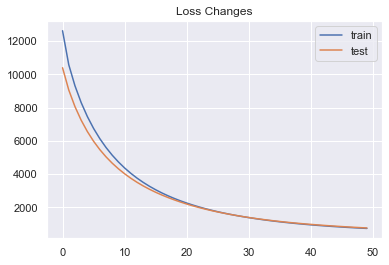

In [75]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss Changes')
plt.legend()
plt.show()

# Prediction

## 6.1 Obtian predictions for test data and train data 

In [44]:
#prediction
train_pre=model.predict(x_train)
test_pre=model.predict(x_test)

## 6.2 Prediction of Train data

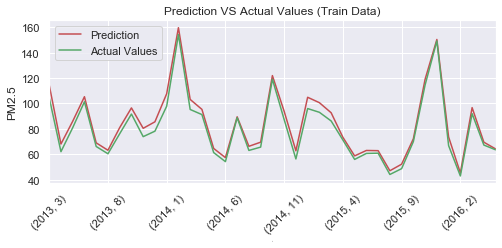

In [48]:
# create data for plot (train data )
plt_df=pd.DataFrame()
plt_df[['year','month']]=train_data[['year','month']][1:]
plt_df['prediction']=train_pre
plt_df['actual_values']=y_train
new_plt_df=plt_df.groupby(['year','month'])['prediction','actual_values'].mean()

# plot 
plt.figure(figsize=(8,3))
new_plt_df['prediction'].plot(color='r',label='Prediction')
new_plt_df['actual_values'].plot(color='g',label='Actual Values')
plt.xlabel('date',fontsize=1)
plt.xticks(rotation=45)
plt.ylabel('PM2.5')
plt.title('Prediction VS Actual Values (Train Data)')
plt.legend()

## 6.3 Prediction of Test Data

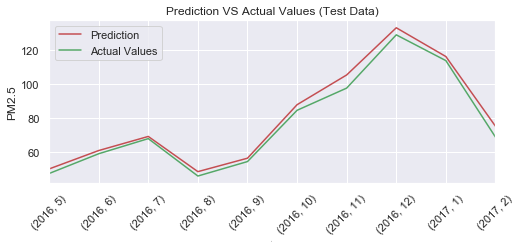

In [47]:
# create data for plot (test data )
plt_df=pd.DataFrame()
plt_df[['year','month']]=test_data[['year','month']][1:]
plt_df['prediction']=test_pre
plt_df['actual_values']=y_test
new_plt_df=plt_df.groupby(['year','month'])['prediction','actual_values'].mean()

# plot 
plt.figure(figsize=(8,3))
new_plt_df['prediction'].plot(color='r',label='Prediction')
new_plt_df['actual_values'].plot(color='g',label='Actual Values')
plt.xlabel('date',fontsize=1)
plt.xticks(rotation=45)
plt.ylabel('PM2.5')
plt.title('Prediction VS Actual Values (Test Data)')
plt.legend()

In [49]:
# Obtian RMSE 
rmse_train = sqrt(mean_squared_error(y_train, train_pre))
rmse_test = sqrt(mean_squared_error(y_test, test_pre))
print('Train RMSE: %.3f' % rmse_train)
print('Test RMSE: %.3f' % rmse_test)


Train RMSE: 18.747
Test RMSE: 18.827


# 7. Evaluate Individual Station Data 

In [107]:
# there are 12 stations, we will exam those datasets individually
print(stations)

['Shunyi', 'Tiantan', 'Huairou', 'Dongsi', 'Guanyuan', 'Changping', 'Nongzhanguan', 'Aotizhongxin', 'Gucheng', 'Wanshouxigong', 'Dingling', 'Wanliu']


In [53]:
# loop and append each station's data
x_train_list=[]
x_test_list=[]
y_train_list=[]
y_test_list=[]
for station in stations:
    train_df=train_data[train_data['station']==station].drop(columns=['station', 'date', 'year', 'month'])
    test_df=test_data[test_data['station']==station].drop(columns=['station', 'date', 'year', 'month'])
    #reshape data
    x_train,x_test,y_train,y_test=reshape_data(train_df,test_df)
    # append data
    x_train_list.append(x_train)
    x_test_list.append(x_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

In [58]:
# check length
len(x_train_list),len(x_test_list),len(y_train_list),len(y_test_list)

(12, 12, 12, 12)

In [81]:
# loop the model for each station's data and obtian the history 
histories=[]
predictions_train=[]
predictions_test=[]
for i in range(0,len(x_train_list)):
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train_list[i].shape[1], x_train_list[i].shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network and append history 
    history = model.fit(x_train_list[i], y_train_list[i], epochs=50, batch_size=72, validation_data=(x_test_list[i], y_test_list[i]),verbose=0 ,shuffle=False)
    histories.append(history)
    #predictions
    pre_train=model.predict(x_train_list[i])
    pre_test=model.predict(x_test_list[i]) 
    # append prediction
    predictions_train.append(pre_train)
    predictions_test.append(pre_test)

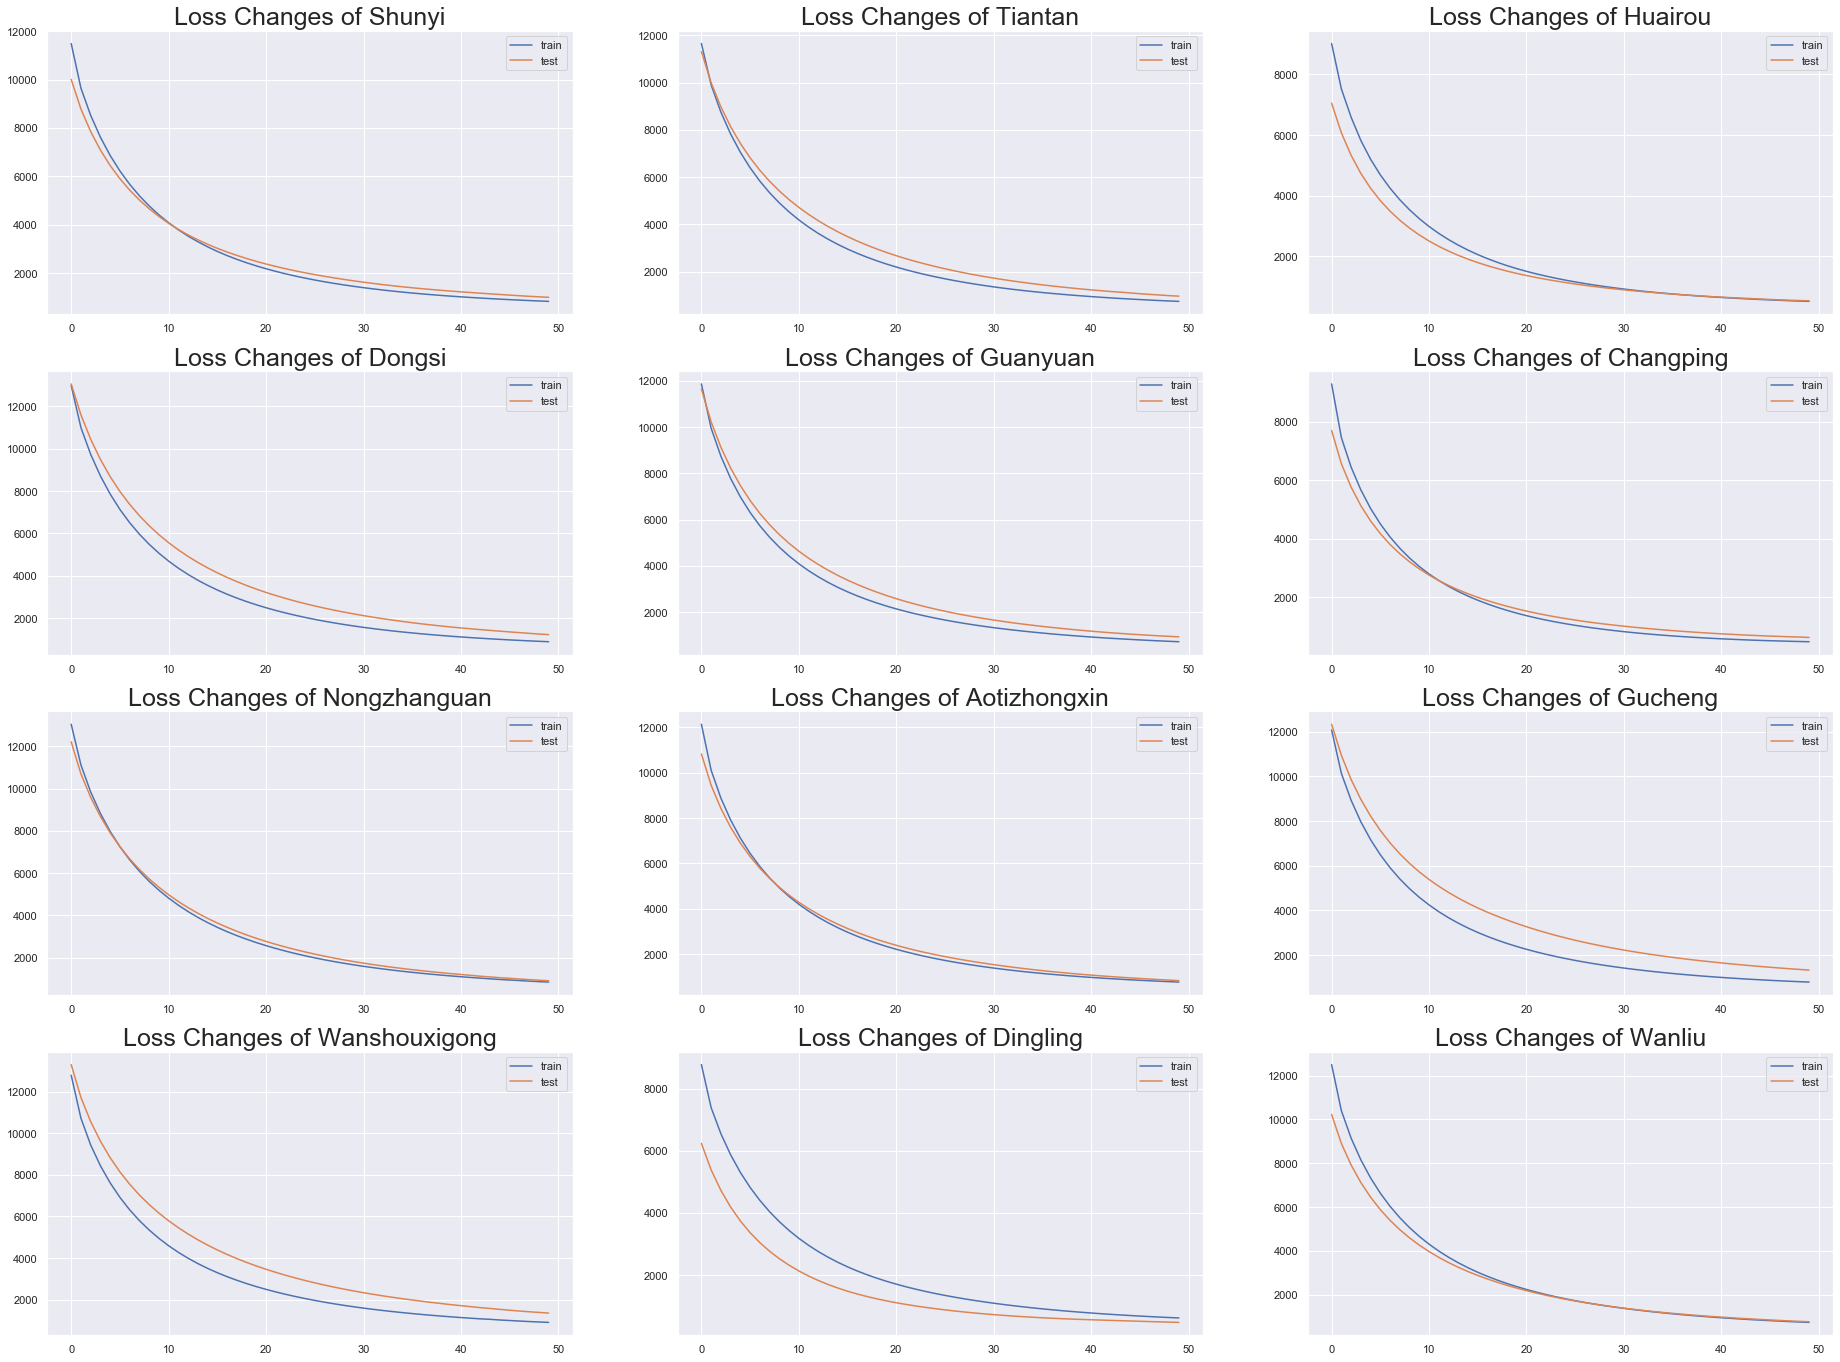

In [82]:
# plot history
plt.figure(figsize=(32,24))
for i in range(0,len(histories)):
    plt.subplot(4,3,i+1)
    plt.plot(histories[i].history['loss'], label='train')
    plt.plot(histories[i].history['val_loss'], label='test')
    plt.title('Loss Changes of {}'.format(stations[i]),fontsize=25)
    plt.legend()
plt.show()

In [83]:
# check the length of predictions 
len(predictions_train),len(predictions_test)

(12, 12)

In [146]:
# obtain the train  axis  and test axis for plot 
train_date=x_train_scaled_data[x_train_scaled_data['station']==stations[0]][['year','month']][1:]
test_date=x_test_scaled_data[x_test_scaled_data['station']==stations[0]][['year','month']][1:]
# check the length, make sure their sizes same
len(train_date),len(predictions_train[0]),len(test_date),len(predictions_test[0])

(28050, 28050, 7012, 7012)

In [132]:
# function to merge lists in one list
import itertools
def merge_list(a):
    return list(itertools.chain.from_iterable(a))
#a=[['a','b'],['c']]   merge_list(a) will return ['a', 'b', 'c']

predictions_Train=[]
for prediction in predictions_train:
    predictions_Train.append(merge_list(prediction))
    
predictions_Test=[]
for prediction in predictions_test:
    predictions_Test.append(merge_list(prediction))

In [137]:
len(predictions_Train),len(predictions_Test)

(12, 12)

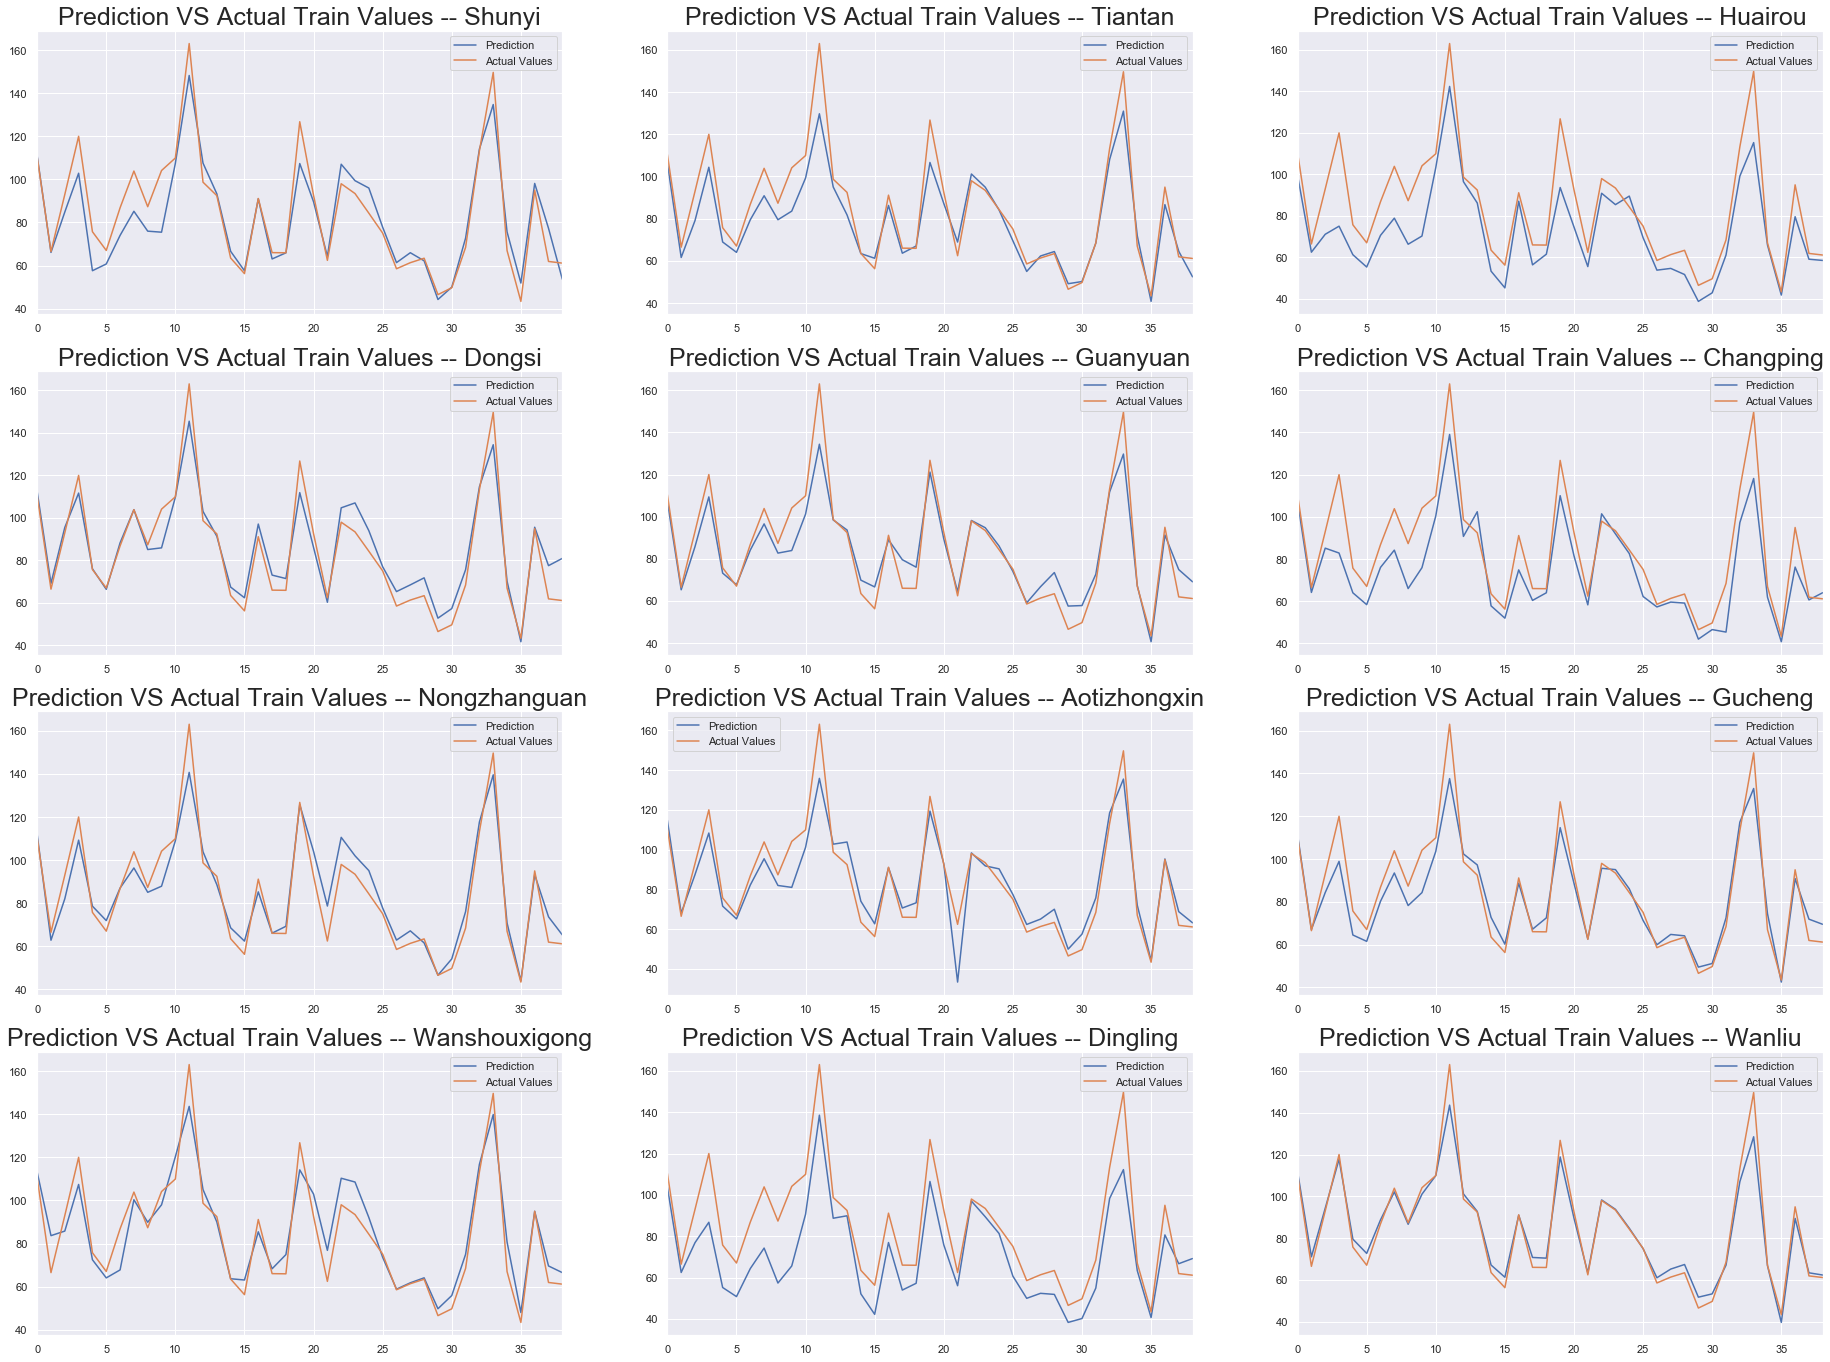

In [182]:
# prepare plot train data
pre_train_df=pd.DataFrame(predictions_Train).T
pre_train_df['year']=list(train_date['year'])
pre_train_df['month']=list(train_date['month'])
pre_train_df['y_train']=list(y_train)
train_plot=pre_train_df.groupby(['year','month'])[[0,1,2,3,4,5,6,7,8,9,10,11,'y_train']].mean().reset_index()
# using loop to plot each stations train data prediction 
plt.figure(figsize=(32,24))
for i in range(0,12):
    plt.subplot(4,3,i+1)
    train_plot[i].plot(label='Prediction',)
    train_plot['y_train'].plot(label='Actual Values')
    plt.title('Prediction VS Actual Train Values -- {}'.format(stations[i]),fontsize=25)
    plt.legend()
plt.show()


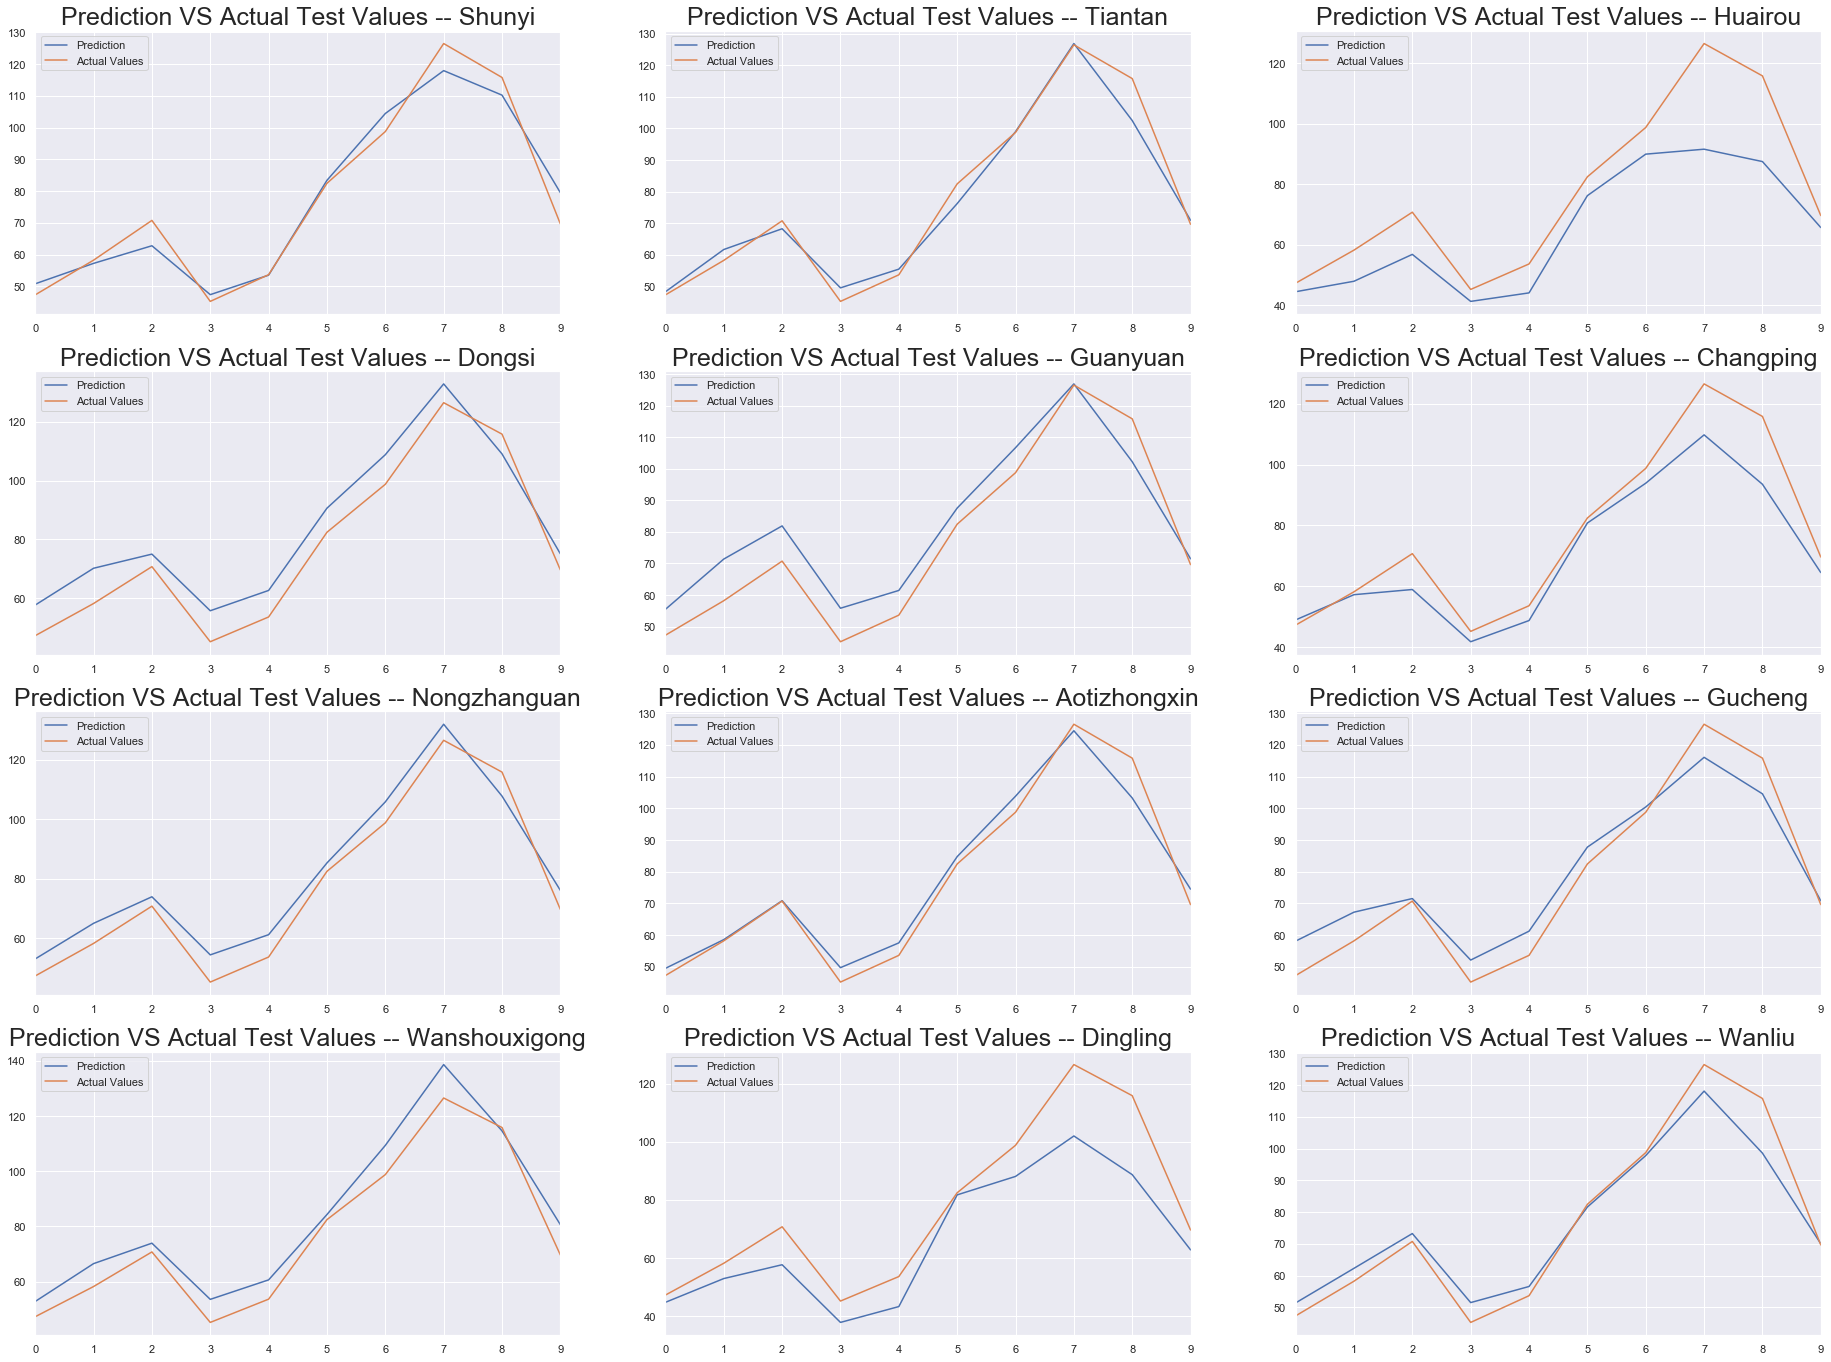

In [183]:
# prepare plot train data
pre_test_df=pd.DataFrame(predictions_Test).T
pre_test_df['year']=list(test_date['year'])
pre_test_df['month']=list(test_date['month'])
pre_test_df['y_test']=list(y_test)
test_plot=pre_test_df.groupby(['year','month'])[[0,1,2,3,4,5,6,7,8,9,10,11,'y_test']].mean().reset_index()
# using loop to plot each stations train data prediction 
plt.figure(figsize=(32,24))
for i in range(0,12):
    plt.subplot(4,3,i+1)
    test_plot[i].plot(label='Prediction',)
    test_plot['y_test'].plot(label='Actual Values')
    plt.title('Prediction VS Actual Test Values -- {}'.format(stations[i]),fontsize=25)
    plt.legend()
plt.show()


# 8. RMSE

In [186]:
# Obtian the RMSE
# Obtian RMSE 
for i in range(0,12): 
    rmse_train = sqrt(mean_squared_error(y_train, predictions_Train[i]))
    rmse_test = sqrt(mean_squared_error(y_test, predictions_Test[i]))
    print('Train RMSE of {}:{}'.format(stations[i],rmse_train))
    print('Test RMSE  of {}:{}'.format(stations[i],rmse_test))
    print('===================================================')

Train RMSE of Shunyi:43.20176230488704
Test RMSE  of Shunyi:42.65963349926233
Train RMSE of Tiantan:37.03484352834357
Test RMSE  of Tiantan:36.714646667313005
Train RMSE of Huairou:46.516734697795854
Test RMSE  of Huairou:45.455141955364745
Train RMSE of Dongsi:36.12347412994987
Test RMSE  of Dongsi:38.801699783094286
Train RMSE of Guanyuan:32.13897460078613
Test RMSE  of Guanyuan:34.38489940895832
Train RMSE of Changping:44.5765596070421
Test RMSE  of Changping:41.4575178569449
Train RMSE of Nongzhanguan:36.69369584386556
Test RMSE  of Nongzhanguan:36.54766170361834
Train RMSE of Aotizhongxin:35.45609883112949
Test RMSE  of Aotizhongxin:32.664873271338266
Train RMSE of Gucheng:35.383397955345494
Test RMSE  of Gucheng:33.39291496642465
Train RMSE of Wanshouxigong:38.131912290728884
Test RMSE  of Wanshouxigong:37.06217248177629
Train RMSE of Dingling:47.144629394873924
Test RMSE  of Dingling:46.91537266908721
Train RMSE of Wanliu:27.046653635170834
Test RMSE  of Wanliu:27.62416511839883